In [72]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir
from scipy import stats

import uproot3

from scipy.stats import trim_mean
rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

#import mplhep as hep
#hep.set_style(hep.style.ROOT)
print(pd.__version__)

0.25.3


In [3]:
#
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

plot_style_1A = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2A = {'alpha': 0.5, 'density': False}


In [5]:
def get_Dataframe(path, name='Data', tag=None):
    Files = listdir(path) 
    #print (Files)
    df = None
    for i, f in enumerate(Files):
        #if( df is not None):
        #    if(df.shape[0]>100000): continue
        #if(i>10):continue
        if name not in f: continue
        filename = path+f
        if not(tag is None) and (tag not in f): continue
        print ('filename is' , filename)
        
        temp_file = uproot3.open(filename)
        
        hasTree = False 
        
        print (temp_file.keys()) 
        
        if(len(temp_file.keys())<1):
            print('could not find %s, skipping'%name)
            continue
        
        if( not(name in str(temp_file.keys()[0]))):
            print('could not find %s, skipping'%name)
            continue
        
        for key in temp_file[name].keys():
            #print (key)
            if('minitree' in str(key)):
                hasTree=True
        if (not hasTree):
            print('file has not minitree, skipping')
            continue

        temp_tree = temp_file[name+'/minitree']

        
        temp_df = None
        
        if 'Data' not in name:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*", "genjet*","Q2","gen_Q2","y",'gen_y',"e_*","gene*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True)
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        else:
            try:
                temp_df   =  temp_tree.pandas.df(["jet*","Q2","y","e_*",'wgt','vertex_z','ptmiss','ptratio*','Empz','pth'], entrystop=3e7,flatten=True) 
                df = pd.concat([df,temp_df])
            except ValueError:
                print ('oops, there is a problem in flattening the TTree ')
        
        #try:
        #    df.shape[0]
        #except ValueError:
        #    print('no valid dataframe')
    print('####################################################################')
    if( not(df is None)):
        print('Dataframe has a total of ', df.shape[0], ' entries')
    else:
        print ('Dataframe has no entry, it is None')
    print('####################################################################')

    return df


In [6]:
def applyCut(inputDataframe, cut, text=None):
    dataframe = inputDataframe
    nbeforecut = dataframe.shape[0]
    cutDataframe = dataframe.query(cut)
    if text:
        print (text, cutDataframe.shape[0], ' fraction kept: %2.1f'%(100.0*float(cutDataframe.shape[0])/nbeforecut))
    return cutDataframe

In [7]:
def applyCutsJets(df,isMC=False):
    temp = df
    #temp = applyCut(temp, 'abs(vertex_z)<25 and vertex_z!=0','abs(vertex_z)<25 and and vertex_z!=0')
    #temp = applyCut(temp, 'tau1b>0 and tau1b<1', '0<tau1b<1')
    temp.eval('jet_px = jet_pt*cos(jet_phi)', inplace=True)
    temp.eval('jet_py = jet_pt*sin(jet_phi)', inplace=True)
    temp.eval('jet_pz = jet_pt*sinh(jet_eta)', inplace=True)

    temp.eval('jet_qt = sqrt( (jet_px + e_px)**2 + (jet_py + e_py)**2) ', inplace=True)
    temp.eval('jet_qtnorm = jet_qt/sqrt(Q2)', inplace=True)
    temp.eval('e_pt = sqrt(e_px*e_px + e_py*e_py)',inplace=True)
    temp.eval('e_phi = arctan(e_py/e_px)', inplace=True)
    temp.eval('jet_phi = arctan(jet_py/jet_px)',inplace=True)
    
    temp.eval('qt_px = jet_px + e_px', inplace=True)
    temp.eval('qt_py = jet_py + e_py', inplace=True)
    temp.eval('qt_phi = arctan(qt_py/qt_px)',inplace=True)
    temp.eval('qt_dot_ept = (qt_px*e_px + qt_py*e_py)/(jet_qt*e_pt)', inplace=True)
    temp.eval('qt_dphi = arccos(qt_dot_ept)', inplace=True)
    temp.eval('qt_cos2phi = cos(2*qt_dphi)', inplace=True)

    temp.eval('jet_dphi = 3.14159265359 -abs(e_phi-jet_phi)',inplace=True)
    temp.eval('logQ2= log(Q2)/2.3025850', inplace=True)
    temp.eval('Q = sqrt(Q2)', inplace=True)
    temp.eval('pthoverpte = pth/e_pt', inplace=True)
    temp = applyCut(temp, 'pass_reco==0 | ptmiss < 10', 'ptmiss<10')

    temp = applyCut(temp, 'pass_reco==0 | 0.08 < y < 0.7', '0.08 < y < 0.7')
    temp = applyCut(temp, 'pass_reco==0 | Q2>150', 'Q2>150')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt>5.0', 'jet pT > 5 GeV')
    temp = applyCut(temp, 'pass_reco==0 | jet_pt<150.0', 'jet pT < 150 GeV')

    temp = applyCut(temp, 'pass_reco==0 | jet_eta>-1.5', 'jet eta > -1.5')
    temp = applyCut(temp, 'pass_reco==0 | jet_eta<2.75', 'jet eta < 2.75')

    if(isMC):
        temp = applyCut(temp,'pass_truth>0',' pass_truth>0')

        temp.eval('gen_logQ2= log(gen_Q2)/2.3025850', inplace=True)   
        temp.eval('gen_Q    = sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_pt = sqrt(gene_px*gene_px + gene_py*gene_py)',inplace=True)
        temp.eval('genjet_px = genjet_pt*cos(genjet_phi)', inplace=True)
        temp.eval('genjet_py = genjet_pt*sin(genjet_phi)', inplace=True)
        temp.eval('genjet_pz = genjet_pt*sinh(genjet_eta)', inplace=True)

        
        temp.eval('genjet_qt = sqrt( (genjet_px + gene_px)**2 + (genjet_py + gene_py)**2) ', inplace=True)
        temp.eval('genjet_qtnorm = genjet_qt/sqrt(gen_Q2)', inplace=True)
        temp.eval('gene_phi = arctan(gene_py/gene_px)', inplace=True)
        temp.eval('genjet_phi = arctan(genjet_py/genjet_px)',inplace=True)
        temp.eval('genjet_dphi = 3.14159265359- abs(gene_phi-genjet_phi)',inplace=True)
        
        temp.eval('genqt_px = genjet_px + gene_px', inplace=True)
        temp.eval('genqt_py = genjet_py + gene_py', inplace=True)
        temp.eval('genqt_phi = arctan(genqt_py/genqt_px)',inplace=True)
        temp.eval('genqt_dot_ept = (genqt_px*gene_px + genqt_py*gene_py)/(genjet_qt*gene_pt)', inplace=True)
        temp.eval('genqt_dphi = arccos(genqt_dot_ept)', inplace=True)
        temp.eval('genqt_cos2phi = cos(2*genqt_dphi)', inplace=True)
        
        temp.eval('res_pt = ((jet_pt-genjet_pt)/genjet_pt)',inplace=True)
        temp.eval('res_qt = ((jet_qt-genjet_qt)/genjet_qt)',inplace=True)

    #    temp.eval('genjet_qtnormept= genjet_qt/e_pt', inplace=True)
    #    temp.eval('genjet_qtnormjetpt= genjet_qt/genjet_pt', inplace=True)


    #df = applyCut(df, 'n_total>1', ' n>1')
    return temp

## Get dataframes, apply selection

In [8]:
#mc_name = 'Django'
#altmc_name = 'Rapgap'

mc_name = 'Rapgap'
altmc_name = 'Django'

In [9]:
mc_tag = 'nominal' ##could be "sys_0 or sys_1, etc"
data_tag  = 'nominal'
period = 'ep0607'

In [10]:

path = '/home/miguel/data/hera/'
data = get_Dataframe(path, name='Data', tag=data_tag)

filename is /home/miguel/data/hera/Data_Eplus0607_0.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_2.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_3.nominal.root
[b'Data;1']
filename is /home/miguel/data/hera/Data_Eplus0607_1.nominal.root
[b'Data;1']
####################################################################
Dataframe has a total of  375783  entries
####################################################################


## Get Signal MC

In [11]:
%%time 
mc = get_Dataframe(path, name=mc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_101.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_107.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_131.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_103.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_4.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_136.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_112.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_144.nominal.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_150.nominal.root
[b'Rapgap;1']
filename

In [12]:
%%time 

altmc = get_Dataframe(path, name=altmc_name, tag=mc_tag)


filename is /home/miguel/data/hera/Django_Eplus0607_8.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_129.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_137.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_134.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_13.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_121.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_151.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_7.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_3.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_116.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_126.nominal.root
[b'Django;1']
filename is /home/miguel/data/hera/Django_Eplus0607_132.nominal.root
[b'Django;1']
filename is

In [13]:
%%time
mc_up = get_Dataframe(path, name=mc_name, tag='sys_0')

filename is /home/miguel/data/hera/Rapgap_Eplus0607_147.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_114.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_3.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_143.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_145.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_139.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_108.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_6.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_126.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera

In [14]:
%%time
altmc_up = get_Dataframe(path, name=mc_name, tag='sys_0')

filename is /home/miguel/data/hera/Rapgap_Eplus0607_147.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_114.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_116.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_117.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_3.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_8.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_143.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_145.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_139.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_108.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_6.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera/Rapgap_Eplus0607_126.sys_0.root
[b'Rapgap;1']
filename is /home/miguel/data/hera

## Define the pass_reco and pass_tuth flags. i.e. whether row in the dataframe jet has a reco-level jet, and whether it has a valid truth-level jet. 

In [15]:
%%time 
mc['pass_reco'] = np.where(mc['jet_pt']>0, 1, 0)
mc['pass_truth'] = np.where(mc['genjet_pt']*mc['Q2']>0, 1, 0)

altmc['pass_reco'] = np.where(altmc['jet_pt']>0, 1, 0)
altmc['pass_truth'] = np.where(altmc['genjet_pt']*altmc['Q2']>0, 1, 0)




CPU times: user 1.38 s, sys: 598 ms, total: 1.98 s
Wall time: 1.57 s


In [16]:
mc_up['pass_reco'] = np.where(mc_up['jet_pt']>0, 1, 0)
mc_up['pass_truth'] = np.where(mc_up['genjet_pt']*mc_up['Q2']>0, 1, 0)

altmc_up['pass_reco'] = np.where(altmc_up['jet_pt']>0, 1, 0)
altmc_up['pass_truth'] = np.where(altmc_up['genjet_pt']*altmc_up['Q2']>0, 1, 0)


In [17]:
%%time 
data['pass_reco'] = np.where(data['jet_pt']>0, 1, 0)

print('Selecting data events\n')
data = applyCutsJets(data)
data.keys()

Selecting data events

ptmiss<10 372273  fraction kept: 99.1
0.08 < y < 0.7 303073  fraction kept: 81.4
Q2>150 259178  fraction kept: 85.5
jet pT > 5 GeV 259178  fraction kept: 100.0
jet pT < 150 GeV 259178  fraction kept: 100.0
jet eta > -1.5 258694  fraction kept: 99.8
jet eta < 2.75 258684  fraction kept: 100.0
CPU times: user 310 ms, sys: 0 ns, total: 310 ms
Wall time: 190 ms


Index(['jet_pt', 'jet_phi', 'jet_eta', 'jet_dphi', 'jet_z', 'Q2', 'y', 'e_px',
       'e_py', 'e_pz', 'wgt', 'vertex_z', 'ptmiss', 'ptratio_da',
       'ptratio_ele', 'Empz', 'pth', 'pass_reco', 'jet_px', 'jet_py', 'jet_pz',
       'jet_qt', 'jet_qtnorm', 'e_pt', 'e_phi', 'qt_px', 'qt_py', 'qt_phi',
       'qt_dot_ept', 'qt_dphi', 'qt_cos2phi', 'logQ2', 'Q', 'pthoverpte'],
      dtype='object')

In [18]:
%%time 
print('Selecting MC events\n')
mc   = applyCutsJets(mc, isMC=True)
print('Selecting MC events\n')
altmc   = applyCutsJets(altmc, isMC=True)



Selecting MC events

ptmiss<10 88561297  fraction kept: 99.7
0.08 < y < 0.7 86599620  fraction kept: 97.8
Q2>150 84206452  fraction kept: 97.2
jet pT > 5 GeV 84206452  fraction kept: 100.0
jet pT < 150 GeV 84206452  fraction kept: 100.0
jet eta > -1.5 84184454  fraction kept: 100.0
jet eta < 2.75 84183898  fraction kept: 100.0
 pass_truth>0 22142629  fraction kept: 26.3
Selecting MC events

ptmiss<10 98331422  fraction kept: 99.6
0.08 < y < 0.7 96427587  fraction kept: 98.1
Q2>150 93632537  fraction kept: 97.1
jet pT > 5 GeV 93632537  fraction kept: 100.0
jet pT < 150 GeV 93632536  fraction kept: 100.0
jet eta > -1.5 93609301  fraction kept: 100.0
jet eta < 2.75 93608656  fraction kept: 100.0
 pass_truth>0 22574692  fraction kept: 24.1
CPU times: user 1min 47s, sys: 58.5 s, total: 2min 46s
Wall time: 2min 16s


In [19]:
print('Selecting MC events\n')
mc_up  = applyCutsJets(mc_up, isMC=True)
print('Selecting MC events\n')
altmc_up   = applyCutsJets(altmc_up, isMC=True)

Selecting MC events

ptmiss<10 87125175  fraction kept: 99.7
0.08 < y < 0.7 85219953  fraction kept: 97.8
Q2>150 82865796  fraction kept: 97.2
jet pT > 5 GeV 82865796  fraction kept: 100.0
jet pT < 150 GeV 82865796  fraction kept: 100.0
jet eta > -1.5 82844092  fraction kept: 100.0
jet eta < 2.75 82843540  fraction kept: 100.0
 pass_truth>0 21790225  fraction kept: 26.3
Selecting MC events

ptmiss<10 87125175  fraction kept: 99.7
0.08 < y < 0.7 85219953  fraction kept: 97.8
Q2>150 82865796  fraction kept: 97.2
jet pT > 5 GeV 82865796  fraction kept: 100.0
jet pT < 150 GeV 82865796  fraction kept: 100.0
jet eta > -1.5 82844092  fraction kept: 100.0
jet eta < 2.75 82843540  fraction kept: 100.0
 pass_truth>0 21790225  fraction kept: 26.3


## Check calibration

## pT DA

[7.5645, 8.785, 10.2025, 11.847999999999999, 13.759, 15.979, 18.557000000000002, 21.5505, 25.027, 29.064, 33.7525, 39.1975, 45.5205, 52.864000000000004, 61.392, 71.2955, 82.797, 96.154, 111.66550000000001]


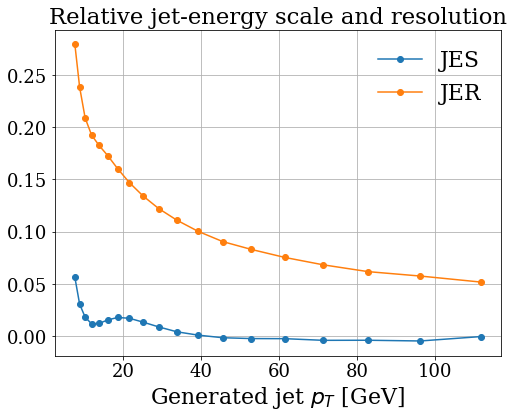

<Figure size 432x288 with 0 Axes>

In [42]:
fig = plt.figure( figsize=(8, 6))
df = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['genjet_pt'], bins=np.geomspace(7,120,20)))['res_pt']
df = df.agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_pt']]
print (x)
plt.plot(x,df['mean'],'o-',label='JES')
plt.plot(x,df['std'],'o-',label='JER')
plt.xlabel('Generated jet $p_{T}$ [GeV]',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_jetpt.png')

In [ ]:
fig = plt.figure( figsize=(8, 6))
query = 'pass_reco==1 and genjet_pt>10'
df = mc.query(query).groupby(pd.cut(mc.query(query)['genjet_eta'], bins=np.linspace(-1.0,2.5,20)))['res_pt'].agg(['mean', 'std', 'size'])
df = df.reset_index()

x = [i.mid for i in df['genjet_eta']]
print (x)
plt.plot(x,df['mean'],'o-',label='JES')
plt.plot(x,df['std'],'o-',label='JER')
plt.xlabel('Generated jet $\eta$',fontsize=22)
plt.legend(fontsize=22)
plt.title('Relative jet-energy scale and resolution')
plt.grid()
plt.show()
plt.tight_layout()
fig.savefig('figures/Jetperformance_jeteta.png')

## Average HFS pT / DA pT vs jet pT

              jet_pt      mean       std     size
0       (5.0, 6.565]  0.959841  0.152419  1737805
1      (6.565, 8.62]  0.954153  0.146802  2135103
2     (8.62, 11.319]  0.967009  0.136786  3047288
3   (11.319, 14.862]  0.991666  0.132239  3491926
4   (14.862, 19.514]  1.029290  0.142134  2901226
5   (19.514, 25.623]  1.057922  0.150705  1996417
6   (25.623, 33.643]  1.053105  0.136384  1106580
7   (33.643, 44.175]  1.039002  0.110425   519669
8   (44.175, 58.003]  1.027177  0.090788   198385
9    (58.003, 76.16]  1.019428  0.075512    69133
10    (76.16, 100.0]  1.025648  0.064568    15418


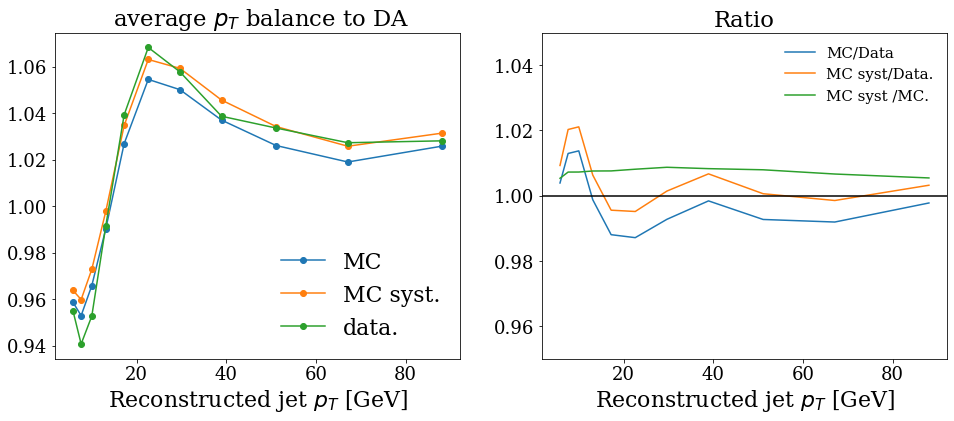

CPU times: user 6.2 s, sys: 2.13 s, total: 8.33 s
Wall time: 7.87 s


<Figure size 432x288 with 0 Axes>

In [85]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()

trim_mean = {}
bins = np.geomspace(5,100,12)
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['MC'] = df_mc.apply(stats.trim_mean, 0.025)
df_mc = df_mc.agg(['mean', 'std', 'size']).reset_index()
print (df_mc)
x = [i.mid for i in df_mc['jet_pt']]
ax[0].plot(x,trim_mean['MC'],'o-',label='MC')



df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['MCsys'],'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_pt'], bins=bins))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
ax[0].plot(x,trim_mean['data'],'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],trim_mean['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(trim_mean['MCsys'],trim_mean['MC'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].axhline(y=1.0,color='black')#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_jetpt.png')

In [ ]:


df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_pt'], bins=np.geomspace(5,100,12)))['ptratio_da']
trim_mean['MCsys'] = df_mc_up.apply(stats.trim_mean, 0.025)
#ax[0].plot(x,trim_mean,'o-',label='MC syst.')


df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_pt'], bins=np.geomspace(5,100,12)))['ptratio_da']
trim_mean['data'] = df_data.apply(stats.trim_mean, 0.025)
#ax[0].plot(x,trim_mean,'o-',label='data.')



ax[0].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(trim_mean['MC'],df_data['data'])
ax[1].plot(x,ratio,label='MC/Data')
ratio = np.true_divide(trim_mean['MCsys'],df_data['data'])
ax[1].plot(x,ratio,label='MC syst/Data.')

ratio = np.true_divide(df_mc_up['MC'],df_mc['MCsys'])
ax[1].plot(x,ratio,label='MC syst /MC.')

ax[1].set_ylim(0.95,1.05)
#ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].axhline(y=0.0)#fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')

ax[1].set_title('Ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_jetpt.png')

In [ ]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['jet_eta']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $\eta$',fontsize=22)

plt.show()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_jeteta.png')

In [ ]:
%%time
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_pt'], bins=np.geomspace(5,100,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_pt'], bins=np.geomspace(5,100,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_pt'], bins=np.geomspace(5,100,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['jet_pt']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')

ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')

ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $p_{T}$ [GeV]',fontsize=22)

plt.show()
plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_ELE_jetpt.png')

In [ ]:
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['jet_eta'], bins=np.linspace(-1.0,2.5,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['jet_eta']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed jet $\eta$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed jet $\eta$',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_ELE_jeteta.png')

## As afunction of electron variables

In [ ]:
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['y']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed $y$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed $y$',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_ELE_y.png')

In [ ]:
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['y'], bins=np.linspace(0.2,0.7,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['y']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed $y$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed $y$',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DATA_y.png')

In [ ]:
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()
df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_ele'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['logQ2']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed log $Q^{2}$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to electron')
ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed log $Q^{2}$',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_ELE_Q2.png')

In [ ]:
fig,ax = plt.subplots(1,2 ,figsize=(16, 6))
ax = ax.flatten()
df_mc = mc.query('pass_reco==1').groupby(pd.cut(mc.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()
df_mc_up = mc_up.query('pass_reco==1').groupby(pd.cut(mc_up.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

df_data = data.query('pass_reco==1').groupby(pd.cut(data.query('pass_reco==1')['logQ2'], bins=np.linspace(2,4,12)))['ptratio_da'].agg(['mean', 'std', 'size']).reset_index()

x = [i.mid for i in df_mc['logQ2']]
ax[0].plot(x,df_mc['mean'],'o-',label='MC')
ax[0].plot(x,df_mc_up['mean'],'o-',label='MC syst.')
ax[0].plot(x,df_data['mean'],'o-',label='data')
ax[0].set_ylim(0.90,1.10)


#plt.plot(x,df['std'],'o-',label='JER')
ax[0].set_xlabel('Reconstructed log $Q^{2}$',fontsize=22)
ax[0].legend(fontsize=22)
ax[0].set_title(' average $p_{T}$ balance to DA')

ratio = np.true_divide(df_mc['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC')

ratio = np.true_divide(df_mc_up['mean'], df_data['mean'])
ax[1].plot(x,ratio,label='MC syst.')
ax[1].set_ylim(0.95,1.05)
ax[1].fill_between(x,0.99,1.01,alpha=0.2,color='black',label='$\pm1\%$')
ax[1].set_title('MC/data ratio')
ax[1].legend()
ax[1].set_xlabel('Reconstructed log $Q^{2}$',fontsize=22)

plt.show()
plt.tight_layout()
fig.savefig('figures/JetCalibrationTest_DA_Q2.png')